In [6]:
# !pip install pennylane
import pennylane as qml
from pennylane import numpy as np

# !pip install matplotlib
import matplotlib.pyplot as plt

In [7]:
# wires 0,1,2 are group B (input training data)
# wires 3,4,5 are group A (store past data)

# initialize a, J values (stays same throughout trainig)
a = []
J = np.zeros((6, 6))
for i in range(6):
  a.append( np.random.uniform(-1.0, 1.0) )
  for j in range(i):
    J[i][j] = np.random.uniform(-1.0, 1.0)

# calculate Hint
coeffs = []
obs = []
for j in range(6):
    coeffs.append(a[j])
    obs.append(qml.PauliX(j))
    for k in range(j):
      coeffs.append(J[j][k])
      obs.append(qml.PauliZ(j) @ qml.PauliZ(k))
Hint = qml.Hamiltonian(coeffs, obs) 

In [8]:
print(Hint)

  (-0.9713298830631443) [X3]
+ (0.04853788442787499) [X4]
+ (0.12660898492667272) [X2]
+ (0.23836332374367797) [X0]
+ (0.29055862119648035) [X5]
+ (0.5484046724272729) [X1]
+ (-0.9531778091686978) [Z5 Z0]
+ (-0.9260377441158871) [Z3 Z2]
+ (-0.7987186799750465) [Z2 Z1]
+ (-0.6295269722920629) [Z1 Z0]
+ (-0.6108003612211823) [Z5 Z2]
+ (-0.60816485226594) [Z5 Z1]
+ (-0.45490050975059404) [Z2 Z0]
+ (-0.37846206990782894) [Z3 Z1]
+ (-0.3530932180118591) [Z4 Z1]
+ (-0.13377983655497583) [Z4 Z3]
+ (-0.08391387531809258) [Z4 Z2]
+ (0.23652733181865715) [Z5 Z3]
+ (0.8806830686798226) [Z3 Z0]
+ (0.8825258422124791) [Z4 Z0]
+ (0.94965535385406) [Z5 Z4]


In [9]:
# is_First_Iteration = 1

# prev_state = np.zeros(12) # Jason: idk what to initialize this as for now? lol

(<Figure size 1600x700 with 1 Axes>, <Axes:>)


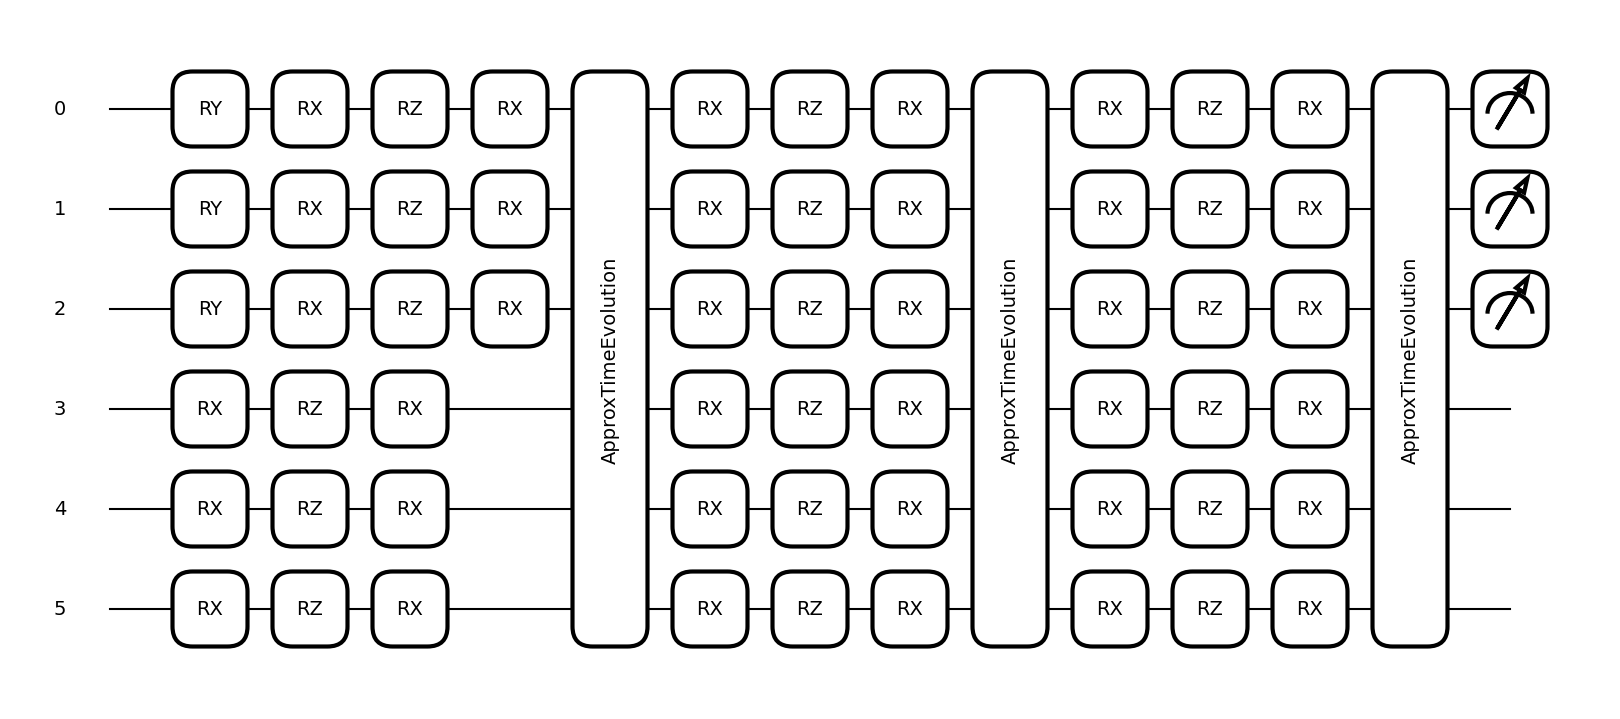

In [10]:
from pennylane.math.utils import requires_grad
# dev = qml.device("default.qubit", wires=6)
# dev1 = qml.device("default.qubit", wires=9)
# dev2 = qml.device("default.qubit", wires=9)

dev1 = qml.device("default.mixed", wires=6)
dev2 = qml.device("default.mixed", wires=6)

# wires 0,1,2 are group B (input training data)
# wires 3,4,5 are group A (store past data)

# initialize a, J values (stays same throughout trainig)
a = []
J = np.zeros((6, 6))
for i in range(6):
  a.append( np.random.uniform(-1.0, 1.0) )
  for j in range(i):
    J[i][j] = np.random.uniform(-1.0, 1.0)

# calculate Hint
coeffs = []
obs = []
for j in range(6):
    coeffs.append(a[j])
    obs.append(qml.PauliX(j))
    for k in range(j):
      coeffs.append(J[j][k])
      obs.append(qml.PauliZ(j) @ qml.PauliZ(k))
Hint = qml.Hamiltonian(coeffs, obs) 
# some fixed values (as specified in paper)
D = 3
tau = 0.2

is_First_Iteration = np.array(1, requires_grad=False)

prev_state = np.zeros(12, requires_grad=False) # Jason: idk what to initialize this as for now? lol

# Parameters
alpha_array = np.zeros((D, 6))
beta_array  = np.zeros((D, 6))
gamma_array = np.zeros((D, 6))
#alpha_array = np.random.rand(D, 6)
#beta_array  = np.random.rand(D, 6)
#gamma_array = np.random.rand(D, 6)
c = np.asarray(1.0)

def encoding(x):
    qml.RY(np.arccos(x), wires=0)
    qml.RY(np.arccos(x), wires=1)
    qml.RY(np.arccos(x), wires=2)

def U1(alpha, beta, gamma, wire):
     qml.RX(alpha, wires=wire)
     qml.RZ(beta, wires=wire)
     qml.RX(gamma, wires=wire)

def evolution(alpha_array, beta_array, gamma_array):
    for i in range (D): # D = 3
        # U1 rotations
        for j in range(6):
            U1(alpha_array[i][j], beta_array[i][j], gamma_array[i][j], j)

        # np.exp(-1.0*j * Hint * tau) # e^(-i Hint tau)
        #change third paramter (larger is more accurate)
        qml.ApproxTimeEvolution(Hint, tau, 1)

@qml.qnode(dev1)
def pqc_expval(x, alpha_array, beta_array, gamma_array, prev_state, is_First_Iteration):

    if (is_First_Iteration == 0):
        # qml.MottonenStatePreparation(state_vector=prev_state, wires=range(6))
        qml.QubitDensityMatrix(state_vector=prev_state, wires=[3,4,5])

    # prev_state = np.zeros(12)
    if (is_First_Iteration == 1):
        is_First_Iteration = 0
       
    # qml.SWAP(wires=[0,6])
    # qml.SWAP(wires=[1,7])
    # qml.SWAP(wires=[2,8])

    encoding(x)
    evolution(alpha_array, beta_array, gamma_array)
    
    # prev_state = qml.state()
    # print("prev_state: ", prev_state)

    # will qml.state() collapse wires before qml.expval returns?

    return [qml.expval(qml.PauliZ(i)) for i in range(3)]
    # return qml.state()

@qml.qnode(dev2)
def pqc_state(x, alpha_array, beta_array, gamma_array, prev_state, is_First_Iteration):

    if (is_First_Iteration == 0):
        # qml.MottonenStatePreparation(state_vector=prev_state, wires=range(6))
        qml.QubitDensityMatrix(state_vector=prev_state, wires=[3,4,5])

    # prev_state = np.zeros(12)
    if (is_First_Iteration == 1):
        is_First_Iteration = 0
       
    # qml.SWAP(wires=[0,6])
    # qml.SWAP(wires=[1,7])
    # qml.SWAP(wires=[2,8])

    encoding(x)
    evolution(alpha_array, beta_array, gamma_array)
    
    # prev_state = qml.state()
    # print("prev_state: ", prev_state)

    # will qml.state() collapse wires before qml.expval returns?

    # return [qml.expval(qml.PauliZ(i)) for i in range(3)], qml.state()
    # return qml.state()
    return qml.density_matrix(wires=[3,4,5])

#def timestep_output(x, weights):
def timestep_output(x, alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration):
# def timestep_output(x, alpha_array, beta_array, gamma_array, c):
    
    # print(qml.draw_mpl(pqc)(0.5))
    #result = pqc(x, weights[0], weights[1], weights[2])
    result = pqc_expval(x, alpha_array, beta_array, gamma_array, prev_state, is_First_Iteration)
    prev_state = pqc_state(x, alpha_array, beta_array, gamma_array, prev_state, is_First_Iteration)

    # print("Output of pqc: ", result)
    # print("Type of pqc: ", result[0])
    
    # y = c * np.average(result)
    y = c * (( result[0] + result[1] + result[2] ) / 3.0)
    # print("Output of each timestep: ", y)

    return y

timestep_output(0.7, alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration)
# timestep_output(0.7, alpha_array, beta_array, gamma_array)
print(qml.draw_mpl(pqc_expval)(0.5, alpha_array, beta_array, gamma_array, prev_state, is_First_Iteration))

# print(qml.draw_mpl(pqc)(0.5, 1))

### random code ideas, unused

# expval1 = qml.expval(qml.PauliZ(0))
# expval2 = qml.expval(qml.PauliZ(1))
# expval3 = qml.expval(qml.PauliZ(2))

# avg = (expval1 + expval2 + expval3) / 3.0

# print([expval1.eigvals(), expval2.eigvals(), expval3.eigvals()])

# return c * avg
# return expval1, expval2, expval3

In [11]:
prev_state

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=False)

In [12]:
timestep_output(0.7, alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration)

tensor(0.47697458, requires_grad=True)

In [13]:
# what is this for again?
len(pqc_expval.qtape.trainable_params)

99

[0.5, 0.4960176792966289, 0.4841341526992536, 0.4645387162638653, 0.43754351123929686, 0.4035785518809927, 0.3631848756323197, 0.31700592478611933, 0.2657772969104507, 0.21031502730689208, 0.15150259015343637, 0.09027682539445106, 0.027613015552254084, -0.035490649824008, -0.098028974601989, -0.15900576811961917, -0.2174497137878965, -0.27242984146753507, -0.32307035715560495, -0.3685645937558894, -0.40818786070719953, -0.44130898778427347, -0.46740037918679916, -0.4860464177621285, -0.4969500854884439, -0.49993769475882865, -0.49496165510027856, -0.4821012312558059, -0.46156128055393036, -0.43366898967835743, -0.3988686628187596, -0.35771464422368554, -0.31086248789424764, -0.2590585150790389, -0.20312792591189485, -0.14396165456558332, -0.08250217730939945, -0.01972849953812636, 0.04335943908177524, 0.10575669293390963, 0.16646931851488053, 0.2245302072414599, 0.27901449079672014, 0.32905427361901873, 0.37385245785585464, 0.4126954405609881, 0.44496448087759005, 0.4701455561363377, 0

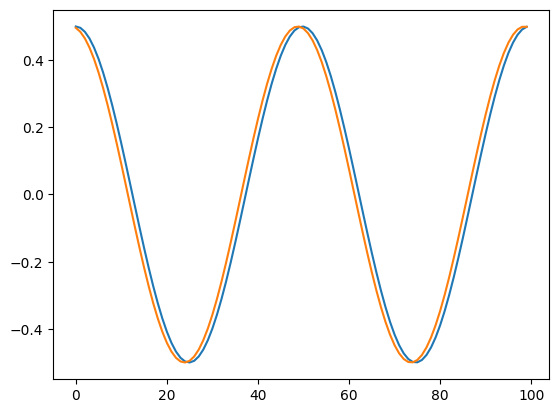

In [14]:
def generate_input(t_in):
    t = 8/199 * t_in
    # if t >= 0 and t <= 1:
    #     return -t + 0.5
    # elif t >= 1 and t <= 2:
    #     return t - 1.5
    # elif t >= 2 and t <= 3:
    #     return -t + 2.5
    # else:
    #     return t - 3.5
    return np.cos(np.pi * t) / 2.0

train_inputs = []
train_expected_outputs = []

for i in range(100):
# for i in range(5):
    train_inputs.append(generate_input(i))
    train_expected_outputs.append(generate_input(i+1))

print(train_inputs)
print(train_expected_outputs)
plt.plot(train_inputs)
plt.plot(train_expected_outputs)

In [15]:
### Lecture 8 Demo helper functions

#def make_predictions(data, model, weights):
def make_predictions(data, model, alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration):

    """Predict the labels of all points in a data set for a given model.
    
    Args:
        data (array[float]): Input data. A list with shape N x 2
            representing points on a 2D plane.
        model (qml.QNode): A QNode whose output expectation value will be
            used to make predictions of the labels of data.
        weights (array[float]): The trainable model parameters for the QNode. 
            
    Returns:
        array[int]: The array of predictions for each data point made by 
        the model QNode. 
    """
    preds = []
    
    for idx in range(len(data)):
        estimated_expval = model(data[idx], alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration)
        
        preds.append(estimated_expval)
            
    return preds

def make_loss_function(data, labels, model):

    #def loss(weights):
    def loss(alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration):
        loss_sum = 0.0

        for idx in range(len(data)):
            point = data[idx]
            true_expval = labels[idx]

            #estimated_expval = model(point, weights)
            estimated_expval = model(point, alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration)
            loss_sum += (estimated_expval - true_expval) ** 2

        return loss_sum / len(data)
    
    return loss

def compute_accuracy(predictions, true_labels):
    """Compute the accuracy of our predictions.
    
    Args:
        predictions (array[int]): Predicted values to 
        true_labels (array[int]): Integers identifying the class/label of 
            each data point.
    
    Returns:
        float: Accuracy of the predictions, returned as a percentage.
    """    
    n_samples = len(predictions)
    
    return np.sum(
        [np.abs(predictions[x]-true_labels[x]) < 0.1 for x in range(n_samples)
    ]) / n_samples

In [16]:
loss = make_loss_function(train_inputs, train_expected_outputs, timestep_output)

In [17]:
gradient_function = qml.grad(timestep_output)

In [18]:
prev_state

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=False)

In [19]:
# tune this parameter!
opt = qml.GradientDescentOptimizer(stepsize=0.1)

n_its = 100

loss_track = []

# weights = [alpha_array, beta_array, gamma_array, c]
# weights = np.array([alpha_array, beta_array, gamma_array, c], requires_grad=True).tolist()

for it in range(n_its):
    # weights, _loss = opt.step_and_cost(loss, weights)
    # Add c as a trainable parameter
    (alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration), _loss = opt.step_and_cost(loss, alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration)

    if it % 5 == 0:
        #our_preds = make_predictions(train_inputs, timestep_output, weights)
        our_preds = make_predictions(train_inputs, timestep_output, alpha_array, beta_array, gamma_array, c, prev_state, is_First_Iteration)
        print(f"Loss at iteration {it} = {_loss}  Accuracy = {compute_accuracy(our_preds, train_expected_outputs)}")
    loss_track.append(_loss)

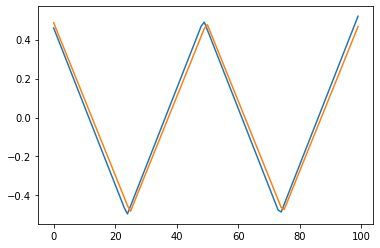

In [ ]:
plt.plot(train_expected_outputs)
plt.plot(our_preds)

In [ ]:
c

tensor(1.09584023, requires_grad=True)

In [ ]:
# weights = np.random.normal(size=(2, 3), requires_grad=True)
weights = np.array([alpha_array, beta_array, gamma_array, c], requires_grad=True).tolist()
weights

/usr/local/lib/python3.9/dist-packages/autograd/numpy/numpy_wrapper.py:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return _np.array(args, *array_args, **array_kwargs)


[array([[-2.58640620e-02,  3.22587927e-03, -1.89661948e-02,
          1.96284510e-03,  2.30031415e-03,  5.99906082e-04],
        [-2.98825459e-02, -1.08014352e-02, -2.22469266e-02,
          9.38421715e-04,  1.17693724e-03,  2.98430591e-04],
        [-3.30365703e-02, -2.01022162e-02, -2.51553535e-02,
         -2.42502582e-19,  3.88180901e-20, -2.37965398e-20]]),
 array([[ 2.29643719e-02, -2.20140393e-03,  1.71166093e-02,
          1.56210608e-07,  2.72425374e-07,  1.62747703e-08],
        [ 1.50083571e-02, -1.46634989e-03,  1.18039995e-02,
          4.54427923e-05, -7.05343490e-05,  6.12327522e-06],
        [ 7.24352509e-03, -5.69863485e-04,  5.96242350e-03,
         -1.76416281e-20,  2.83641060e-20,  3.75053896e-21]]),
 array([[-2.55292962e-02,  3.19652602e-03, -1.87370228e-02,
          1.96284510e-03,  2.30031413e-03,  5.99906082e-04],
        [-2.96660451e-02, -1.08196872e-02, -2.20658269e-02,
          9.38425385e-04,  1.17693056e-03,  2.98430733e-04],
        [-3.29421648e-02, -2